In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from tqdm.notebook import tqdm

In [3]:
import os
os.environ['LOGURU_LEVEL'] = 'INFO'

In [4]:
import logging

from loguru import logger

class InterceptHandler(logging.Handler):
    def emit(self, record):
        # Get corresponding Loguru level if it exists
        try:
            level = logger.level(record.levelname).name
        except ValueError:
            level = record.levelno

        # Find caller from where originated the logged message
        frame, depth = logging.currentframe(), 2
        while frame.f_code.co_filename == logging.__file__:
            frame = frame.f_back
            depth += 1

        logger.opt(depth=depth, exception=record.exc_info).log(level, record.getMessage())

logging.basicConfig(handlers=[InterceptHandler()], level=0)

In [5]:
in_dir = Path('../../data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_training_18M_without_Finnish')
in_dir.is_dir()

True

In [6]:
with open(in_dir/'NL'/'NL1'/'17.txt') as f:
    lines = f.readlines()

In [7]:
def remove_label_and_nl(line):
    return line.strip()[14:]

ocr_aligned = remove_label_and_nl(lines[1])
gs_aligned = remove_label_and_nl(lines[2])

In [9]:
from dataclasses import dataclass, field
import edlib

def normalized_ed(ed, ocr, gs):
    score = 0.0
    l = max(len(ocr), len(gs))
    if l > 0:
        score = ed / l
    return score


@dataclass
class Token:
    ocr: str
    gs: str
    ocr_aligned: str
    gs_aligned: str
    start: int
    ed: int
    score: float = field(init=False)

    def __post_init__(self):
        self.score = normalized_ed(self.ed, self.ocr_aligned, self.gs_aligned)
        


def tokenize_aligned(ocr_aligned, gs_aligned, sentence_start=0):

    ocr_cursor = 0

    ocr_token_chars = []
    gs_token_chars = []
    ocr_token_chars_aligned = []
    gs_token_chars_aligned = []
    start_char = 0

    tokens = []

    for ocr_aligned_char, gs_aligned_char in zip(ocr_aligned, gs_aligned):
        #print(ocr_aligned_char, gs_aligned_char, ocr_cursor)
        if ocr_aligned_char != '@':
            ocr_cursor += 1

        if ocr_aligned_char == ' ' and gs_aligned_char == ' ':
            #print('TOKEN')
            #print('OCR:', repr(''.join(ocr_token_chars)))
            #print(' GS:', repr(''.join(gs_token_chars)))
            #print('start:', start_char)

            ed = edlib.align(''.join(ocr_token_chars_aligned), ''.join(gs_token_chars_aligned))

            tokens.append(Token(''.join(ocr_token_chars), 
                                ''.join(gs_token_chars), 
                                ''.join(ocr_token_chars_aligned), 
                                ''.join(gs_token_chars_aligned), 
                                sentence_start+start_char,
                                ed['editDistance']))

            ocr_token_chars = []
            gs_token_chars = []
            ocr_token_chars_aligned = []
            gs_token_chars_aligned = []
            start_char = ocr_cursor
        else:
            # TODO: handle # in gs(?)
            ocr_token_chars_aligned.append(ocr_aligned_char)
            gs_token_chars_aligned.append(gs_aligned_char)
            if ocr_aligned_char != '@':
                ocr_token_chars.append(ocr_aligned_char)
            if gs_aligned_char != '@':
                gs_token_chars.append(gs_aligned_char)
    ed = edlib.align(''.join(ocr_token_chars_aligned), ''.join(gs_token_chars_aligned))
    tokens.append(Token(''.join(ocr_token_chars), 
                        ''.join(gs_token_chars), 
                        ''.join(ocr_token_chars_aligned), 
                        ''.join(gs_token_chars_aligned), 
                        sentence_start+start_char,
                        ed['editDistance']))

    return tokens

tokens = tokenize_aligned(ocr_aligned, gs_aligned)

In [10]:
print(tokens[3])

Token(ocr='S\\£.', gs='N°.', ocr_aligned='S\\£.', gs_aligned='@N°.', start=32, ed=3, score=0.75)


In [14]:
import nltk.data
import edlib

@dataclass
class Sentence:
    ocr: str
    gs: str
    ocr_aligned: str
    gs_aligned: str
    start: int
    tokens: list
    ed: int
    score: float = field(init=False)

    def __post_init__(self):
        self.score = normalized_ed(self.ed, self.ocr_aligned, self.gs_aligned)


def clean(string):
    string = string.replace('@', '')
    string = string.replace('#', '')

    return string

def extract_sentences(in_file):
    with open(in_file) as f:
        lines = f.readlines()

    ocr_aligned = remove_label_and_nl(lines[1])
    gs_aligned = remove_label_and_nl(lines[2])

    sentences = []
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

    for i, (start, end) in enumerate(sent_detector.span_tokenize(gs_aligned)):
        gs_sentence = gs_aligned[start: end]
        ocr_sentence = ocr_aligned[start: end]
        #print(start, end)
        #print(gs_sentence)
        #print(ocr_sentence)

        ed = edlib.align(ocr_sentence, gs_sentence)
        

        tokens = tokenize_aligned(ocr_sentence, gs_sentence, sentence_start=start)
        sent = Sentence(clean(ocr_sentence), clean(gs_sentence), ocr_sentence, gs_sentence, start, tokens, ed['editDistance'])
        sentences.append(sent)
    return sentences

In [15]:
sentences = extract_sentences(in_dir/'NL'/'NL1'/'17.txt')

In [16]:
sentences[0]

Sentence(ocr='Europijcbe Donderdaeghs Courant S\\£.', gs=' Europische Donderdaeghs Courant N°.', ocr_aligned='@Europijcbe Donderdaeghs Courant S\\£.', gs_aligned=' Europische Donderdaeghs Courant @N°.', start=0, tokens=[Token(ocr='Europijcbe', gs=' Europische', ocr_aligned='@Europijcbe', gs_aligned=' Europische', start=0, ed=3, score=0.2727272727272727), Token(ocr='Donderdaeghs', gs='Donderdaeghs', ocr_aligned='Donderdaeghs', gs_aligned='Donderdaeghs', start=11, ed=0, score=0.0), Token(ocr='Courant', gs='Courant', ocr_aligned='Courant', gs_aligned='Courant', start=24, ed=0, score=0.0), Token(ocr='S\\£.', gs='N°.', ocr_aligned='S\\£.', gs_aligned='@N°.', start=32, ed=3, score=0.75)], ed=6, score=0.16216216216216217)

In [17]:
%%time
data = {}
# df of sentence scores
scores = []
languages = []

for language_dir in in_dir.iterdir():
    #print(language_dir.stem)
    language = language_dir.stem
    
    for text_file in tqdm(language_dir.rglob('*.txt'), desc=language):
        #print(text_file)
        #print(text_file.relative_to(in_dir))
        key = text_file.relative_to(in_dir)
        data[key] = extract_sentences(text_file)
        for s in data[key]:
            scores.append(s.score)
            languages.append(language)


CPU times: user 1min 40s, sys: 7.02 s, total: 1min 47s
Wall time: 2min 17s


In [20]:
df = pd.DataFrame({'score': scores,
                   'language': languages})

In [21]:
df.score.describe()

count    134929.000000
mean          0.256188
std           0.231022
min           0.000000
25%           0.108911
50%           0.225000
75%           0.292453
max           1.000000
Name: score, dtype: float64

<AxesSubplot:>

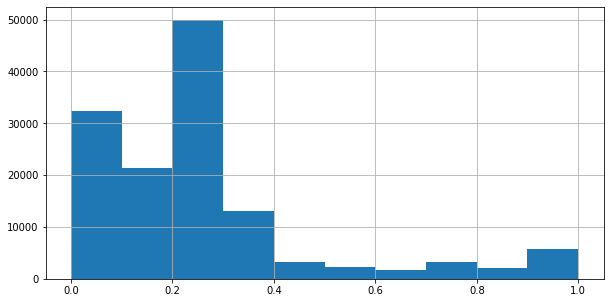

In [25]:
df.score.hist(figsize=(10, 5))

In [24]:
for t in tokens:
    print(t)
    break

Token(ocr='Europijcbe', gs=' Europische', ocr_aligned='@Europijcbe', gs_aligned=' Europische', start=0, ed=3, score=0.2727272727272727)


To test whether the tokenization is correct, we compare the extracted token strings with the unaligned OCR input text. Sometimes, this text contains alignment characters, and if we remove those, the alignment is correct.

In [51]:
ocr_unaligned = remove_label_and_nl(lines[0])
ocr_unaligned = ocr_unaligned.replace('@', '')

for t in tokens:
    try:
        assert t.ocr == ocr_unaligned[t.start:t.start+len(t.ocr)]
    except AssertionError:
        print(t)
        print(ocr_unaligned[t.start:t.start+len(t.ocr)])

In [63]:
result = {}

for i, t in enumerate(tokens):
    if t.ocr != t.gs:
        #print(t)
        #print(t.start)
        #print(len(t.ocr.split()))
        task1_result = f'{t.start}:{len(t.ocr.split())}'
        #print(task1_result)
        result[task1_result] = {}

In [64]:
result

{'0:1': {},
 '32:1': {},
 '37:1': {},
 '42:1': {},
 '57:1': {},
 '66:1': {},
 '69:1': {},
 '78:1': {},
 '88:2': {},
 '95:1': {},
 '105:1': {},
 '113:1': {},
 '122:2': {},
 '146:2': {},
 '154:1': {},
 '161:1': {},
 '168:1': {},
 '172:1': {},
 '178:1': {},
 '184:2': {},
 '196:1': {},
 '199:1': {},
 '206:1': {},
 '213:3': {},
 '221:1': {},
 '230:1': {},
 '236:1': {},
 '246:1': {},
 '255:1': {},
 '269:1': {},
 '280:1': {},
 '290:1': {},
 '304:2': {},
 '309:1': {},
 '315:1': {},
 '319:1': {},
 '323:1': {},
 '335:2': {},
 '365:1': {},
 '371:1': {},
 '375:1': {},
 '385:1': {},
 '395:1': {},
 '398:2': {},
 '417:1': {},
 '422:1': {},
 '429:1': {},
 '442:1': {},
 '456:1': {},
 '459:1': {},
 '463:1': {},
 '471:1': {},
 '480:1': {},
 '491:1': {},
 '495:1': {},
 '506:1': {},
 '509:1': {},
 '513:1': {},
 '518:1': {},
 '521:1': {},
 '528:1': {},
 '541:2': {},
 '548:1': {},
 '552:1': {},
 '555:1': {},
 '576:1': {},
 '587:1': {},
 '592:1': {},
 '606:1': {},
 '613:1': {},
 '624:1': {},
 '632:1': {},
 '6

In [69]:
output = {
    'NL/NL1/17.txt': result
}

In [70]:
import json
with open('result.json', 'w') as f:
    json.dump(output, f, indent=2)